### Series Temporales
#### HW 01: Predicción Ingresos Apple
##### Marta Alejandra Llanos Rodriguez

#### Estructura documento: 
1. Preparación de los datos 
2. Graficar la serie
3. Modelo ETS
4. Modelo ARIMA
5. Preguntas 

##### 1. Preparación de los datos

In [955]:
#Importamos las librerias
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import copy

import warnings
warnings.filterwarnings('ignore')

In [956]:
df= pd.read_csv('aapl_ok.csv', sep=';')
df_copy = df.copy()

In [957]:
df_copy.head()

,Trimeste,fecha,Ingresos
0,Q1 1990,12/29/1989,"1493,4"
1,Q2 1990,03/30/1990,"1346,2"
2,Q3 1990,06/29/1990,"1364,8"
3,Q4 1990,09/28/1990,"1354,1"
4,Q1 1991,12/28/1990,"1675,5"


In [958]:
df.head()

,Trimeste,fecha,Ingresos
0,Q1 1990,12/29/1989,"1493,4"
1,Q2 1990,03/30/1990,"1346,2"
2,Q3 1990,06/29/1990,"1364,8"
3,Q4 1990,09/28/1990,"1354,1"
4,Q1 1991,12/28/1990,"1675,5"


In [959]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Trimeste  127 non-null    object
 1   fecha     127 non-null    object
 2   Ingresos  127 non-null    object
dtypes: object(3)
memory usage: 3.1+ KB


Cambiamos los fortmatos de fecha, ingresos y separamos el trimestre del año

In [960]:
df['fecha'] = pd.to_datetime(df['fecha'],format="mixed")
df['Ingresos'] = pd.to_numeric(df.Ingresos.str.replace(',', '.') )
df[['Trimestre', 'Año']] = df['Trimeste'].str.split(' ', expand=True)
df['Año'] = pd.to_numeric(df.Año )

In [961]:
df.set_index('fecha', inplace=True)

In [962]:
df= df.drop('Trimeste', axis=1)

In [963]:
df.dtypes

Ingresos     float64
Trimestre     object
Año            int64
dtype: object

##### 2. Graficar la serie

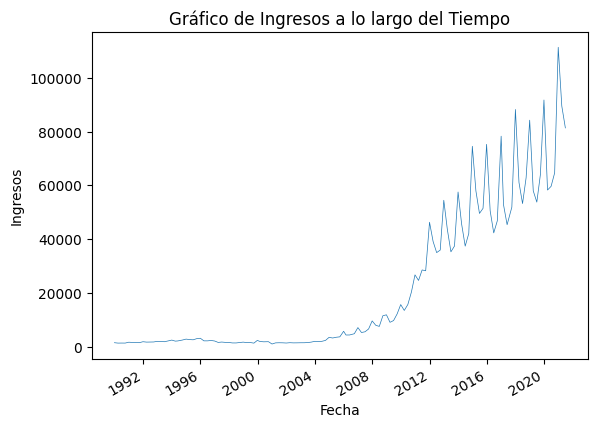

In [964]:
df['Ingresos'].plot(linewidth=0.5)
plt.title('Gráfico de Ingresos a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ingresos')
plt.show()

In [965]:
años_a_mantener = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
df_filtrado = df[df['Año'].isin(años_a_mantener)]

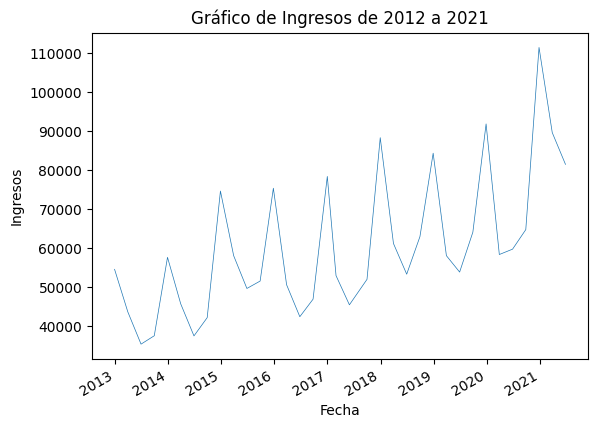

In [966]:
df_filtrado['Ingresos'].plot(linewidth=0.5)
plt.title('Gráfico de Ingresos de 2012 a 2021')
plt.xlabel('Fecha')
plt.ylabel('Ingresos')
plt.show()

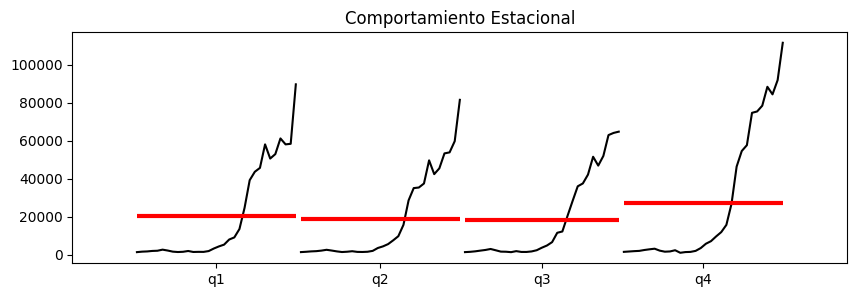

In [967]:
estdf = df.set_index(pd.PeriodIndex(df.index, freq="Q"))
fig, ax = plt.subplots(figsize=(10, 3))

sm.graphics.tsa.quarter_plot(estdf['Ingresos'], ax=ax)
ax.set_title('Comportamiento Estacional')

plt.savefig('Comportamientoestacional.jpg')
plt.show()

En el gráfico anterior podemos ver que hay estacionalidad. Durante los 3 primeros trimestres del año los ingresos se mantenen más o menos constantes, sin embargo en el cuarto trimestre los ingresos aumentan para volver a caer en el primer trimestre. Esto nos puede indicar que apple vende más en periodos de navidad. 

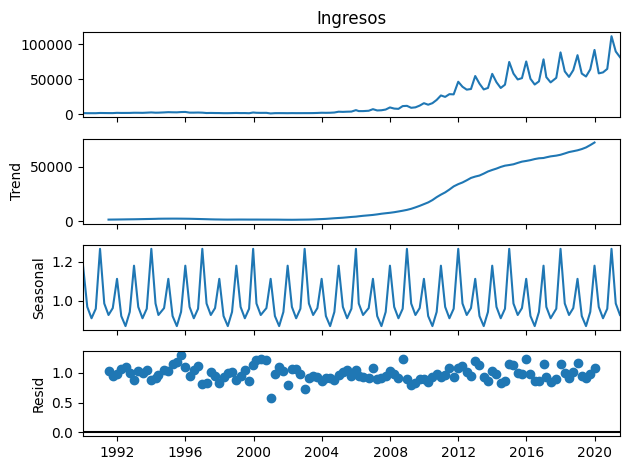

In [968]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Ingresos'], 
                                   model='multiplicative', 
                                   period=12)

decomposition.plot()
plt.savefig('Descomposition.jpg')

Este dataset tiene tanto tendencia, ascendente, como estacionalidad que aumenta según aumenta la tendencia. 

In [969]:
df.head()

,Ingresos,Trimestre,Año
fecha,,,
1989-12-29,1493.4,Q1,1990
1990-03-30,1346.2,Q2,1990
1990-06-29,1364.8,Q3,1990
1990-09-28,1354.1,Q4,1990
1990-12-28,1675.5,Q1,1991


### 3. Modelo ETS 

##### Definir el modelo

In [970]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS

In [971]:
df['Ingresos'].astype('float64').to_period('Q')
ingresos= df['Ingresos'].astype('float64').to_period('Q')

119 8


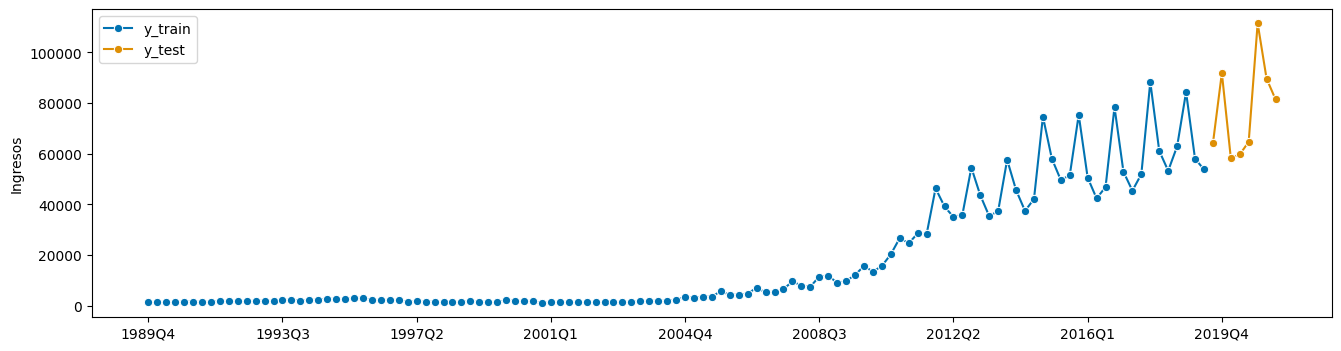

In [972]:
y_train, y_test = temporal_train_test_split(y = df['Ingresos'].astype('float64').to_period('Q'), test_size=8) #Dejamos fuera 8 trimestres
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

Tenemos que introducir componente estacional puesto que en el periodo de Q1 siempre baja, mientas que en Q4 se encuentra en su momento más alto. 

##### Entrenar el modelo

In [973]:
# Paso 2: Definir el horizonte de pronóstico
fh = np.arange(1, 15) #Predizco los 8 trimestres que hemos dejado fuera y 6 más 

# step 3: Definir el algoritmo de pronóstico
df_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)

df_auto_model.fit(y_train) 

AutoETS(auto=True, n_jobs=-1, sp=4)

In [974]:
print(df_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  119
Model:                       ETS(MAM)   Log Likelihood                -968.025
Date:                Mon, 09 Oct 2023   AIC                           1956.050
Time:                        11:23:18   BIC                           1983.841
Sample:                    12-31-1989   HQIC                          1967.335
                         - 06-30-2019   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4225      0.055      7.739      0.000       0.316       0.530
smoothing_trend        0.1685      0.034      4.890      0.000       0.101       0.236
smoothing_seasonal  

El código determina que el mejor modelo ETS es MAM: 
- El error es multiplicativo
- El componente estacional aditivo
- La tendencia es multiplicativa

In [975]:
#Paso 5: Consultando predicciones
df_pred = df_auto_model.predict(fh)
print(df_pred)

2019Q3    58581.326742
2019Q4    85963.040159
2020Q1    59751.798679
2020Q2    53079.526151
2020Q3    58323.465808
2020Q4    85584.234646
2021Q1    59488.205472
2021Q2    52845.108937
2021Q3    58065.604875
2021Q4    85205.429133
2022Q1    59224.612265
2022Q2    52610.691722
2022Q3    57807.743942
2022Q4    84826.623619
Freq: Q-DEC, Name: Ingresos, dtype: float64


In [976]:
df_pred_ints = df_auto_model.predict_interval(fh, coverage=0.9)
df_pred_ints

Ingresos               
                 0.9               
               lower          upper
2019Q3  46046.489981   72578.038617
2019Q4  64602.602964  108150.525105
2020Q1  43884.951471   79792.193750
2020Q2  34964.587889   74196.008127
2020Q3  34359.214546   89861.994941
2020Q4  44142.335772  138626.878452
2021Q1  27512.668039  100562.440664
2021Q2  18407.797219   96628.445184
2021Q3  16962.963652  116434.342106
2021Q4  17645.871009  179334.293889
2022Q1   7494.226624  131183.057023
2022Q2   2332.775921  123082.835809
2022Q3  -2073.751517  152107.747076
2022Q4 -10546.385172  228502.598848

##### Producir predicciones

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

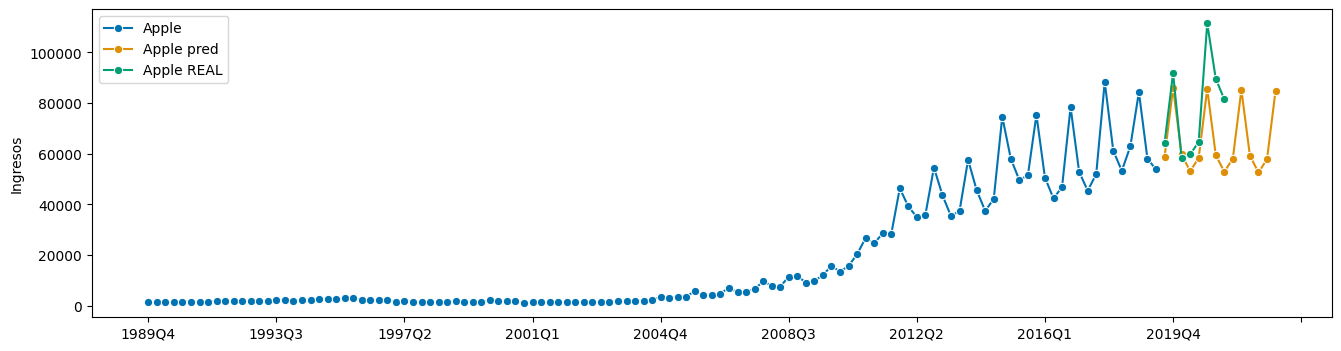

In [977]:
plot_series(y_train, df_pred,y_test, labels=["Apple", "Apple pred", "Apple REAL"])

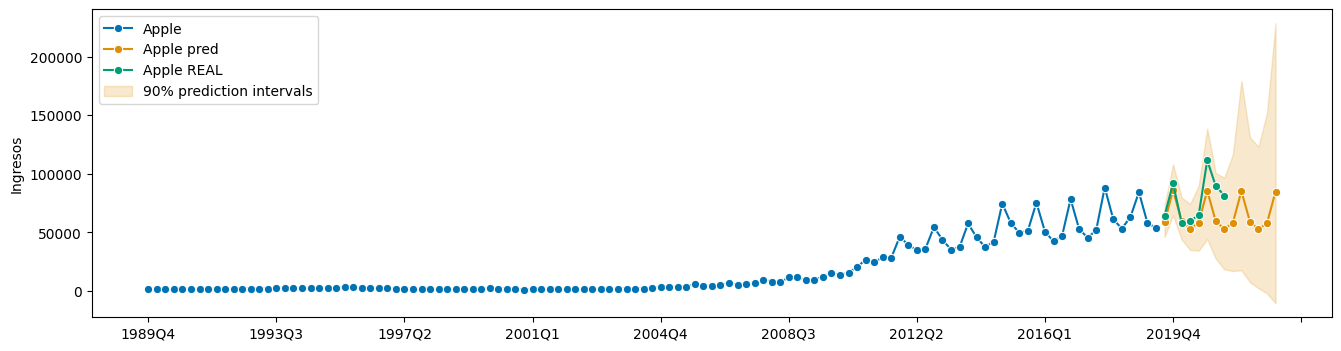

In [978]:
fig, ax = plot_series(y_train, df_pred, y_test, labels=["Apple", "Apple pred", "Apple REAL"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    df_pred_ints[('Ingresos', 0.9, 'lower')],
    df_pred_ints[('Ingresos', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')


Aunque el modelo no haya predecido correctamente los datos, los puntos se encuentran dentro del intervalo de confianza. 

Ampliamos el gráfico para ver el restultado en pleno crecimiento, a partir del 2011

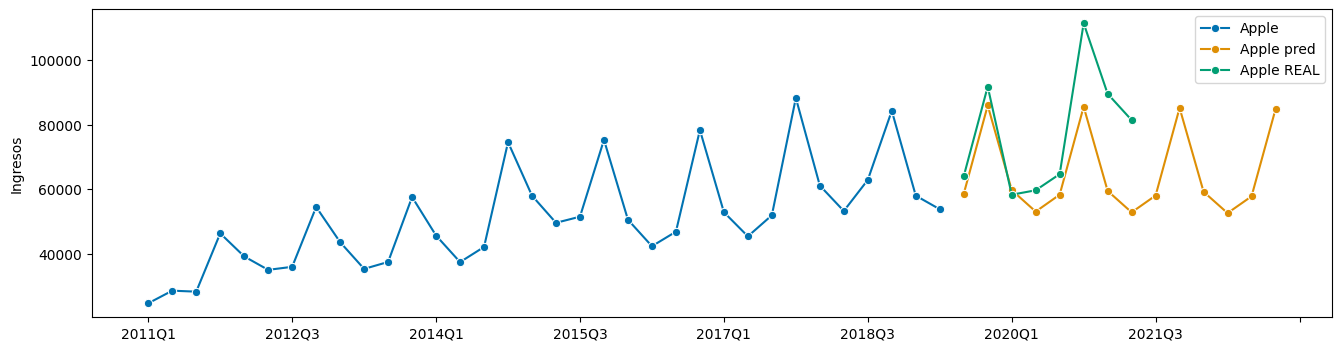

In [979]:
plot_series(y_train["2011":], df_pred,y_test, labels=["Apple", "Apple pred", "Apple REAL"])
plt.savefig('ModeloETS.jpg')

##### Verificar desempeño del modelo

In [980]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, df_pred[0:8])

0.16273953082780607

In [981]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, df_pred[0:8])

317747115.49760485

In [982]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, df_pred[0:8])

17825.462560550983

Aunque en promedio el MAPE no es muy alto, el Error medio cuadrático si, lo que nos indica que las predicciones están bastante alejadas de los valores reales. Vamos a comprobar si esto mejora con el modelo ARIMA. 

### 4. Modelo ARIMA

##### Graficar la serie

Primero vamos a normalizar los datos con logaritmos puesto que podemos observar que en el dataset original cuanto más aumenta la tendencia, más aumenta la varianza. 

In [983]:
df_ts_q=df['Ingresos'].astype('float64').to_period('Q').sort_index()
df_ts_q.tail()

fecha
2020Q2     59685.0
2020Q3     64698.0
2020Q4    111439.0
2021Q1     89584.0
2021Q2     81434.0
Freq: Q-DEC, Name: Ingresos, dtype: float64

In [984]:
from sktime.transformations.series.boxcox import LogTransformer
transformer = LogTransformer()
log_df_ts= transformer.fit_transform(df_ts_q)
log_df_ts.tail()

fecha
2020Q2    10.996836
2020Q3    11.077486
2020Q4    11.621233
2021Q1    11.402932
2021Q2    11.307548
Freq: Q-DEC, Name: Ingresos, dtype: float64

Text(0.5, 1.0, 'Ingresos Apple: Transformación LOG')

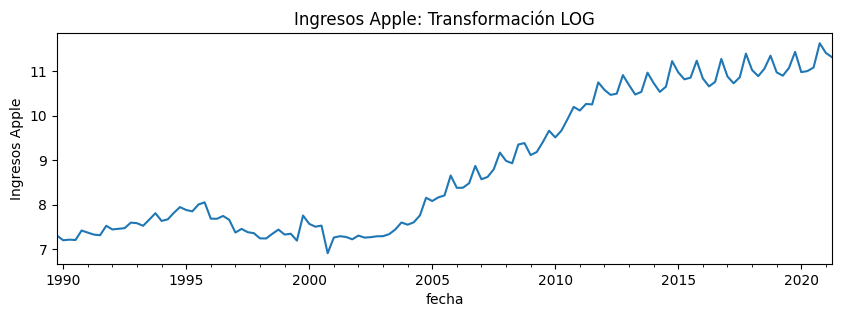

In [985]:
plt.figure(figsize=(10, 3)) 
ax = log_df_ts.plot( linestyle='-')
ax.set_ylabel('Ingresos Apple')
ax.set_title('Ingresos Apple: Transformación LOG')

Text(0.5, 1.0, 'Ingresos Apple: Transformación LOG')

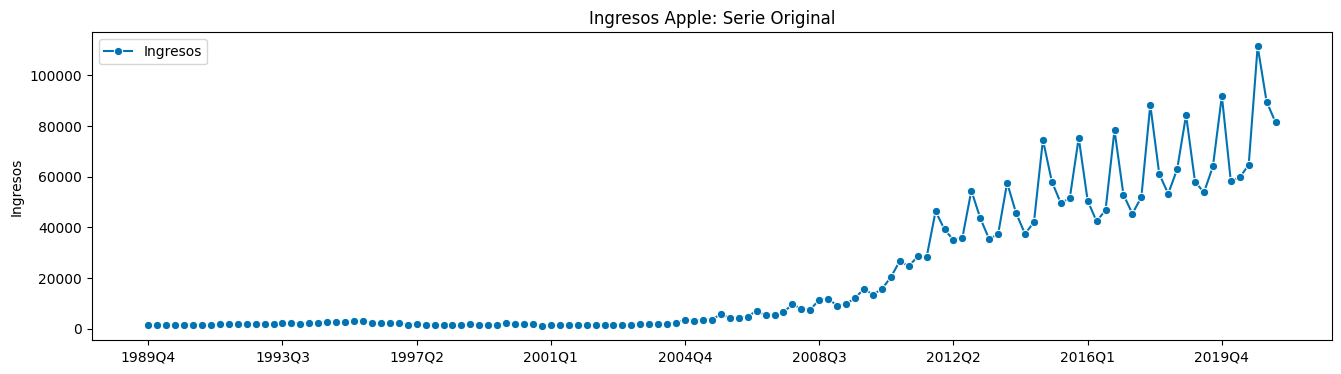

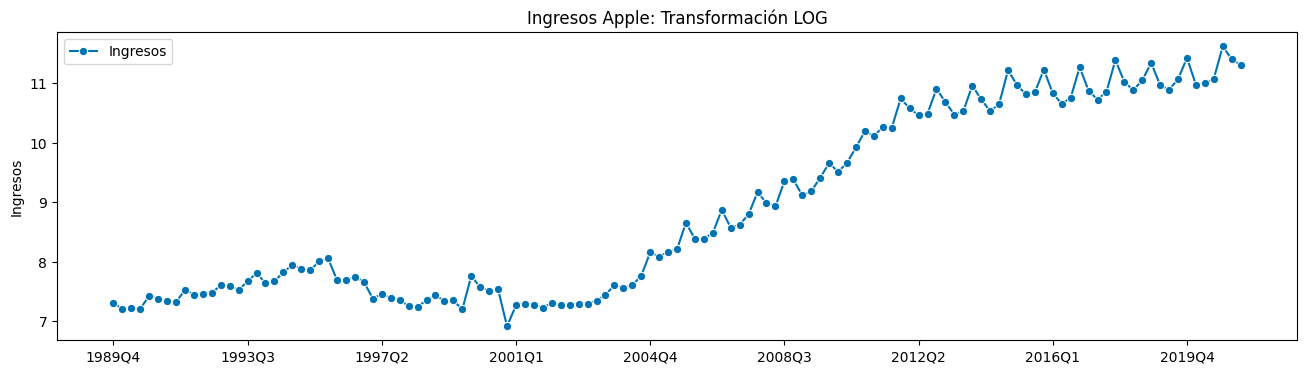

In [986]:
fig, ax =plot_series(df_ts_q, labels=["Ingresos"])
ax.set_title('Ingresos Apple: Serie Original')
fig, ax =plot_series(log_df_ts, labels=["Ingresos"])
ax.set_title('Ingresos Apple: Transformación LOG')

Comparando estos dos gráficos podemos ver que se ha reducido la varianza en la tendencia. 

##### Definir el modelo

119 8


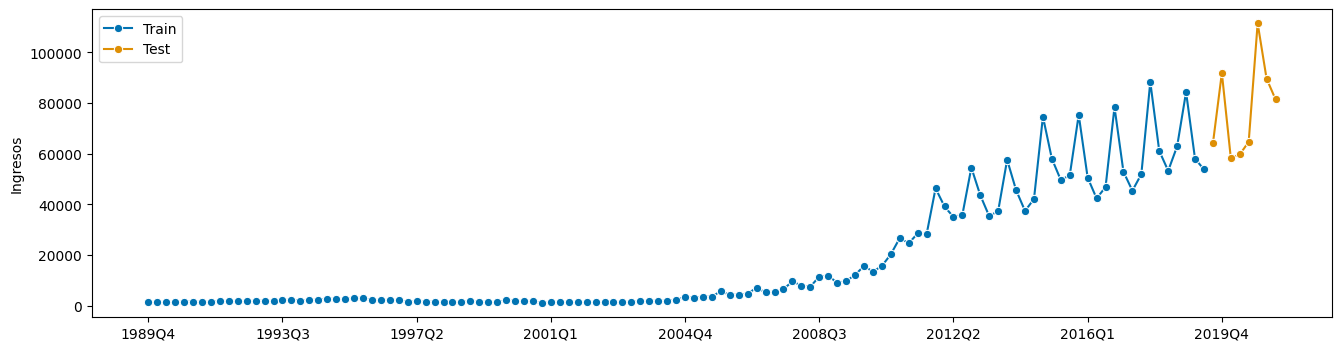

In [987]:
# Seleccionamos la muestras de entrenamiento y prueba tanto para las muestras originales como para las logaritmicas
y_train_ar, y_test_ar = temporal_train_test_split(y =df_ts_q, test_size=8)
log_y_train, log_y_test = temporal_train_test_split(y =log_df_ts, test_size=8)
plot_series(y_train_ar, y_test_ar, labels=["Train", "Test"])
print(y_train_ar.shape[0], y_test_ar.shape[0])

###### Logaritmica

In [988]:
fh_ar = np.arange(1, 15)
fh_ar 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [989]:
from sktime.forecasting.arima import AutoARIMA
forecaster_arima = AutoARIMA(sp=4,suppress_warnings=True)
forecaster_arima.fit(log_y_train)

AutoARIMA(sp=4, suppress_warnings=True)

In [990]:
print(forecaster_arima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood                  58.362
Date:                           Mon, 09 Oct 2023   AIC                           -108.724
Time:                                   11:23:35   BIC                            -97.642
Sample:                               12-31-1989   HQIC                          -104.224
                                    - 06-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3363      0.089     -3.795      0.000      -0.510      -0.163
ar.S.L4        0.9156      0.062     14.822

##### Producir predicciones

In [991]:
log_y_pred = forecaster.predict(fh_ar)
log_y_pred

2019Q3    11.005156
2019Q4    11.335685
2020Q1    11.027218
2020Q2    10.934801
2020Q3    11.039462
2020Q4    11.342086
2021Q1    11.059661
2021Q2    10.975046
2021Q3    11.070872
2021Q4    11.347947
2022Q1    11.089365
2022Q2    11.011894
2022Q3    11.099629
2022Q4    11.353314
Freq: Q-DEC, Name: Ingresos, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

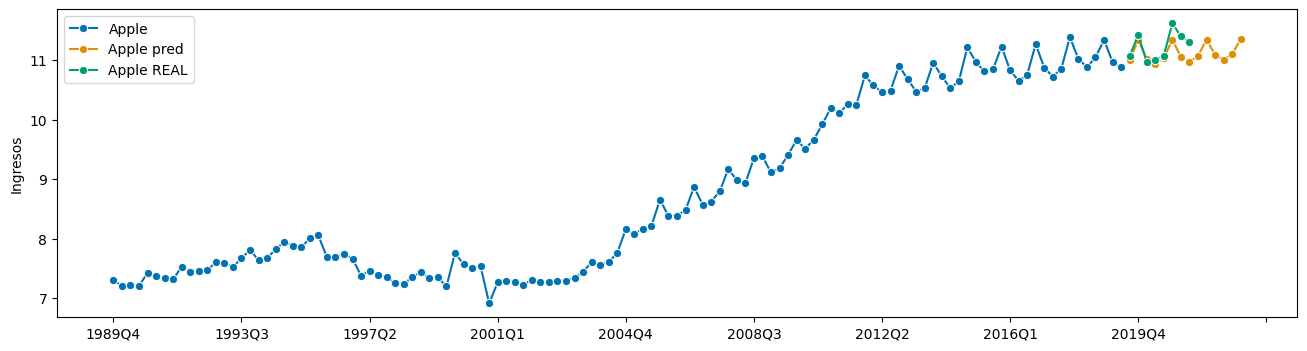

In [992]:
plot_series(log_y_train, log_y_pred,log_y_test, labels=["Apple", "Apple pred", "Apple REAL"])

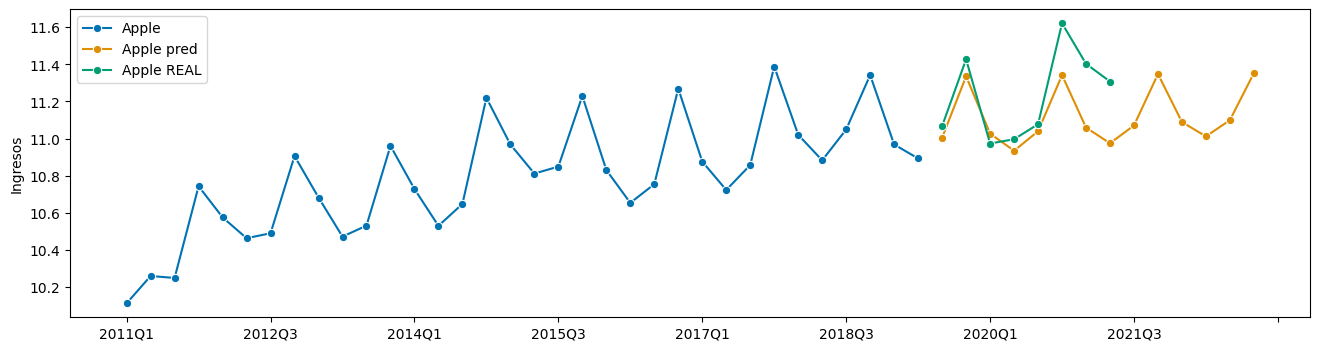

In [993]:
plot_series(log_y_train["2011":], log_y_pred,log_y_test, labels=["Apple", "Apple pred", "Apple REAL"])
plt.savefig('ModeloARIMA.jpg')

##### Verificar desempeño del modelo

In [994]:
np.exp(log_y_pred);

In [995]:
mean_absolute_percentage_error(log_y_test, log_y_pred[0:8])

0.013892973614064611

In [996]:
mean_absolute_percentage_error(y_test_ar, np.exp(log_y_pred[0:8]))

0.13969639733058992

In [997]:
rmse = MeanSquaredError(square_root=True)
rmse(log_y_test, log_y_pred[0:8])

0.20210986175416867

In [998]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, np.exp(log_y_pred[0:8]))

16022.608324659994

En comparación con el modelo ETS, las predicciones del modelo ARIMA se aproximan mucho más a la realidad, puesto que los errores cuadráticos medios y los porcentajes de errores absolutos son significativamente más bajos en el modelo ARIMA.

### 5. Preguntas

#### 1. ¿Los ingresos de Apple son estacionarios? ¿En media? ¿En varianza?

Los ingresos de Apple Son estacionarios puesto que aumentan en el cuarto trimestre y vuelven a disminuir en el primero, manteniendose constante el resto. 

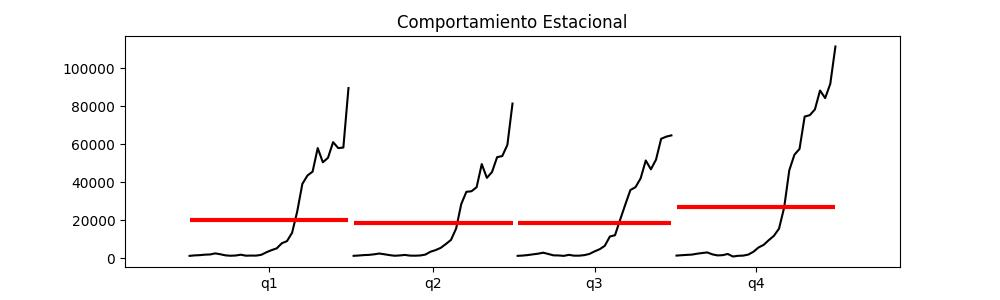

In [999]:
from PIL import Image
from IPython.display import display

imagen = Image.open('Comportamientoestacional.jpg')
display(imagen)

Aunque los ingresos varian según el trimestre, no tiene una estacionalidad ni por media ni por varianza ya que tiene una tendencia creciente, lo que hace variar la media y a medida que pasa el tiempo la varianza es mayor. 

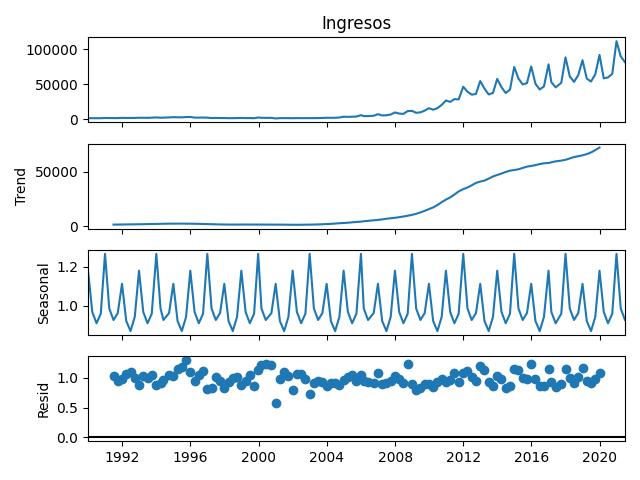

In [1000]:
imagen = Image.open('Descomposition.jpg')
display(imagen)

#### 2. ¿Cuál es su tendencia? ¿y su componente estacional?

Su tendencia, como se observa en los anteriores gráficos, es creciente y además tiene componente estacional, ya como se puede ver en el gráfico inferior, en los últimos años ha seguido el mismo patrón. 

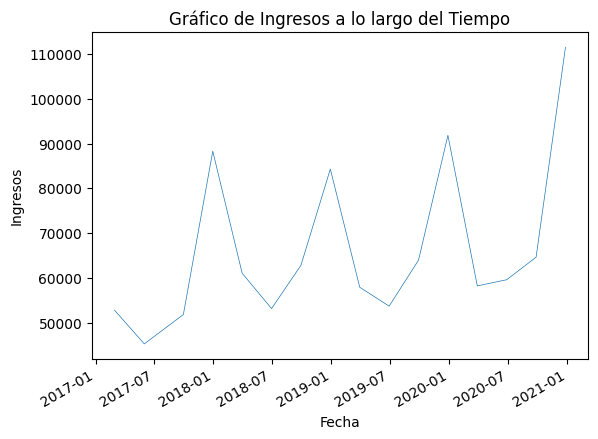

In [1001]:
df['Ingresos']["2017":"2020"].plot(linewidth=0.5)
plt.title('Gráfico de Ingresos a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ingresos')
plt.show()

#### 3. ¿Cuales son las ventas anuales de Apple?

In [1002]:
df_copy['Ingresos'] = pd.to_numeric(df_copy.Ingresos.str.replace(',', '.') )
df_copy['fecha'] = pd.to_datetime(df_copy['fecha'],format="mixed")
df_copy[['Trimestre', 'Año']] = df_copy['Trimeste'].str.split(' ', expand=True)
df_copy['Año'] = pd.to_numeric(df_copy.Año )
ventas_anuales = df_copy.groupby('Año')['Ingresos'].sum()

In [1003]:
ventas_anuales

Año
1990      5558.5
1991      6308.9
1992      7086.5
1993      7977.0
1994      9188.8
1995     11062.0
1996      9833.0
1997      7081.0
1998      5941.0
1999      6134.0
2000      7983.0
2001      5363.0
2002      5742.0
2003      6207.0
2004      8279.0
2005     13931.0
2006     19315.0
2007     24578.0
2008     36669.0
2009     42905.0
2010     65225.0
2011    108249.0
2012    156508.0
2013    170910.0
2014    182795.0
2015    233715.0
2016    215091.0
2017    228594.0
2018    265595.0
2019    260174.0
2020    274515.0
2021    282457.0
Name: Ingresos, dtype: float64

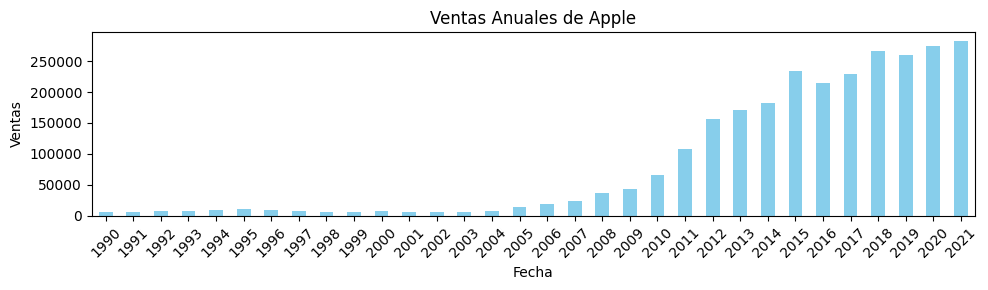

In [1004]:

plt.figure(figsize=(10, 3))
ventas_anuales.plot(kind='bar', color='skyblue')
plt.title('Ventas Anuales de Apple')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#### 4. ¿Cuales son los crecimientos anuales de los ingresos?

In [1005]:
crecimiento_anual = ventas_anuales.pct_change() * 100
crecimiento_anual.round(2).head()


Año
1990      NaN
1991    13.50
1992    12.33
1993    12.57
1994    15.19
Name: Ingresos, dtype: float64

posx and posy should be finite values
posx and posy should be finite values


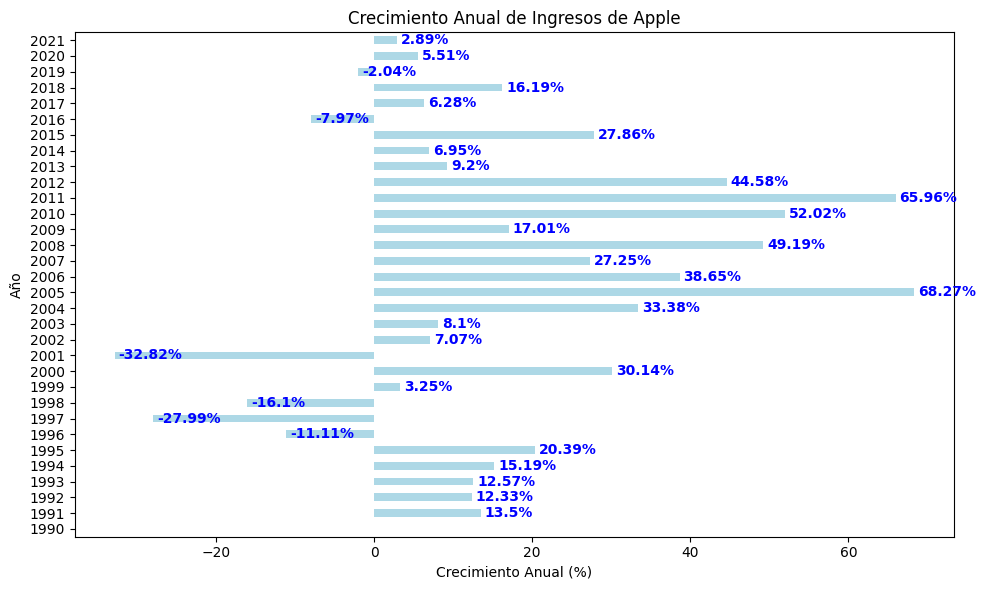

In [1006]:
plt.figure(figsize=(10, 6))
crecimiento_anual.plot(kind='barh', color='lightblue')
plt.title('Crecimiento Anual de Ingresos de Apple')
plt.xlabel('Crecimiento Anual (%)')
plt.ylabel('Año')

# Agregar los porcentajes al lado de las columnas
for i, v in enumerate(crecimiento_anual.round(2)):
    plt.text(v + 0.5, i, str(v) + '%', color='blue', va='center', fontweight='bold')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

#### 5.  ¿Qué modelo predice mejor?

##### Modelo ETS

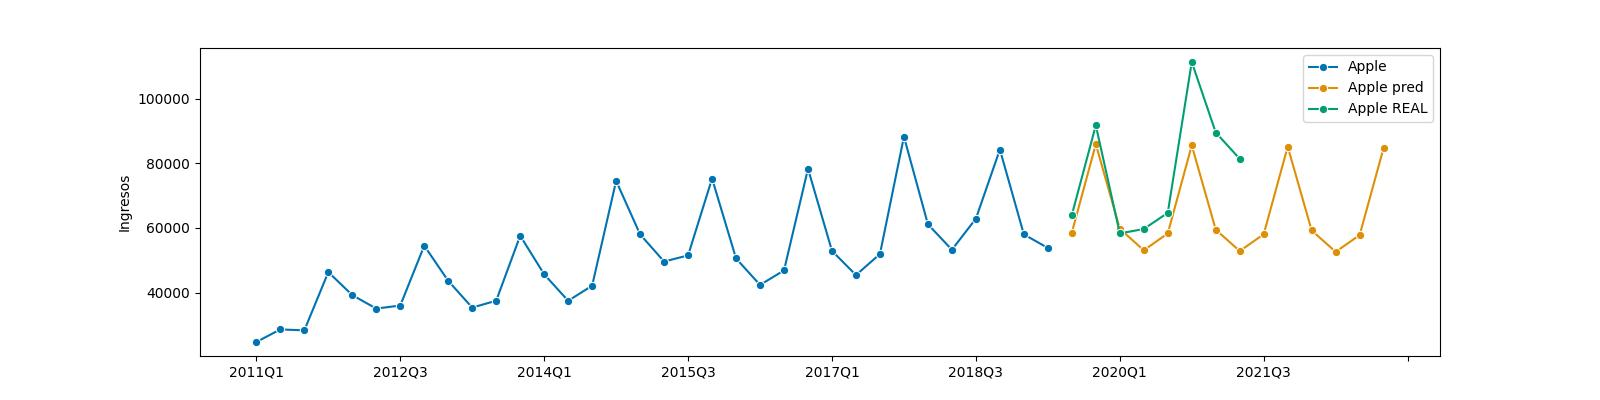

In [1007]:
imagen = Image.open('ModeloETS.jpg')
display(imagen)

##### Modelo Arima

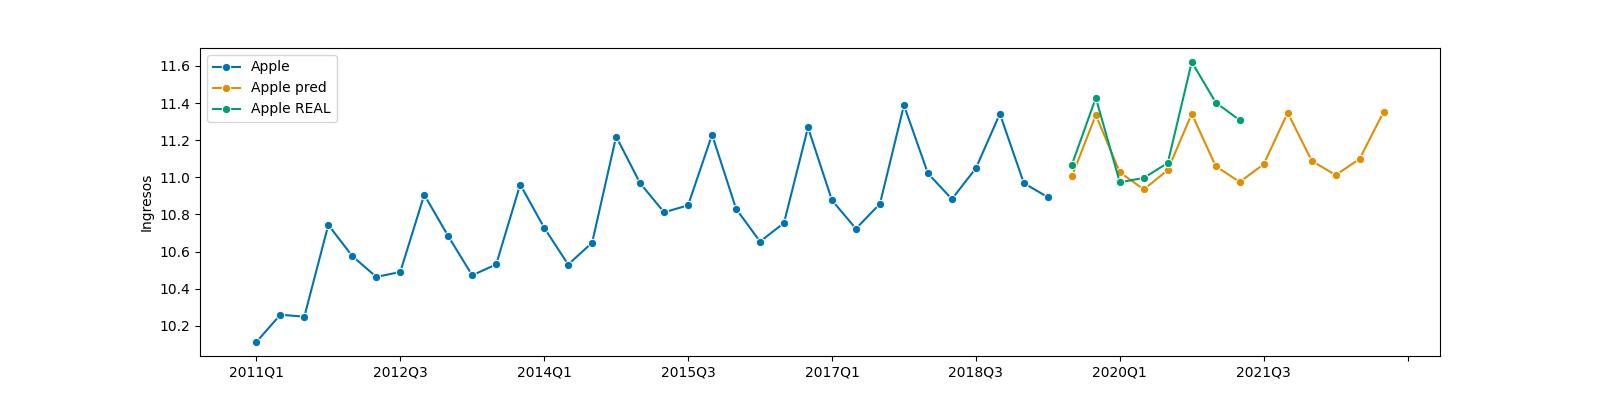

In [1008]:
imagen = Image.open('ModeloARIMA.jpg')
display(imagen)

He seleccionado a partir del 2011 para tener una mejor percepción de la predicción. Como se puede observar, en ambos modelos se precide de una forma más aproximada a corto plazo. Sin embargo a medida que pasa el tiempo el error es mayor. 

No obstante, el modelo ARIMA es el que mejor predice y menor error tiene, aunque habría que mejorar el modelo. 

#### 6. ¿Existe efecto COVID? Cuantificar.


El covid apareció en el primer trimestre de 2020, por lo que haremos una seleción desde el 2018 hasta el final del dataset. 

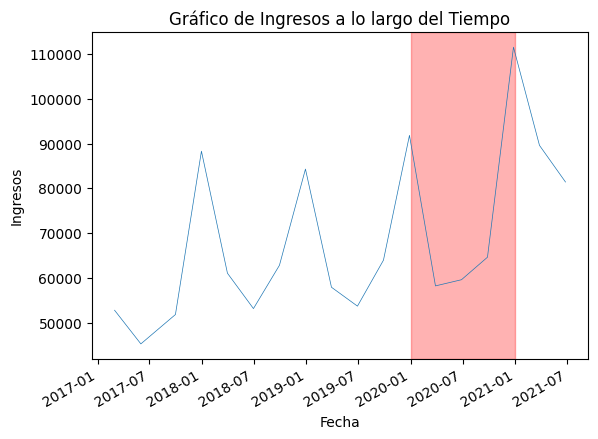

In [1009]:
df['Ingresos']["2017":].plot(linewidth=0.5)
plt.title('Gráfico de Ingresos a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ingresos')

# Agregamos un cuadrado resaltando el año 2020
plt.axvspan('2020-01-01', '2020-12-31', color='red', alpha=0.3)

plt.show()

In [1010]:
df_pred['2019Q3':'2021Q2'];

In [1011]:
ingresos2= ingresos['2019Q3':'2021Q2']

In [1012]:
diferencia = df_pred - ingresos2
diferencia['2019Q3':'2021Q2']

2019Q3    -5458.673258
2019Q4    -5855.959841
2020Q1     1438.798679
2020Q2    -6605.473849
2020Q3    -6374.534192
2020Q4   -25854.765354
2021Q1   -30095.794528
2021Q2   -28588.891063
Freq: Q-DEC, Name: Ingresos, dtype: float64

El covid no afectó en el primer cuatrimestre, pero a partir del segundo los ingresos se vieron altamente afectados.

#### 7. ¿Cuales son las ventas acumuladas para el año 2021? ¿Y para el 2022?

##### Modelo ARIMA
Elegimos el modelo arima puesto que es el que mejor resultados nos ha dado

In [1013]:
ventas2122= np.exp(log_y_pred['2021Q1':'2022Q4'])
ventas2122;

In [1014]:
ventas2122_df = pd.DataFrame(ventas2122)
ventas2122_df.reset_index(inplace=True)
ventas2122_df.rename(columns={'index': 'Trimestre'}, inplace=True)
ventas2122_df['Trimestre'] = ventas2122_df['Trimestre'].astype(str)
ventas2122_df['Año'] = ventas2122_df['Trimestre'].str[:4] 
ventas2122_df['Trimestre'] = ventas2122_df['Trimestre'].str[4:]
ventas2122_df['Ingresos'] = ventas2122_df['Ingresos'].round(2)

ventas2122_df

,Trimestre,Ingresos,Año
0,Q1,63555.02,2021
1,Q2,58398.54,2021
2,Q3,64271.50,2021
3,Q4,84791.23,2021
4,Q1,65471.19,2022
5,Q2,60590.53,2022
6,Q3,66146.64,2022
7,Q4,85247.46,2022


In [1015]:
ingresos_por_año = ventas2122_df.groupby('Año')['Ingresos'].sum().reset_index()
ingresos_por_año['Ingresos'] = ingresos_por_año['Ingresos'].round(2)
ingresos_por_año

,Año,Ingresos
0,2021,271016.29
1,2022,277455.82


#### 8. ¿Son creíbles las predicciones del Barclays?


En las predicciones de Barclays se nota el efecto covid. En 2020 a partir del segundo trimestre se nota una bajada de los ingresos. 

Las predicciones si que pueden llegar a ser creíbles puesto que hay un aumento escalonado de los ingresos cada trimestre. Sin embargo las predicciones realizadas en este notebook se podrían mejorar con el empleo de otros modelos predictivos más avanzados. 